# Del Desorden Visual al Significado: Una Aventura con Transformers y Donut

En aquest notebook aprendrem a:

- Controlar un dispositiu Android amb **adb** i (opcionalment) **scrcpy**
- Fer detecció d’objectes *zero-shot* amb **DETR**
- Extreure text de missatges amb **Tesseract OCR**
- Generar respostes automàtiques amb **Ollama**
- Escriure i enviar missatges via ADB



### Estructura del Notebook

Aquest notebook està organitzat en les següents seccions principals:

#### 📦 **Secció 0-1: Instal·lació i Setup**
- Instal·lació de dependències (Tesseract, llibreries Python)
- Càrrega de models (DETR preentrenat, Ollama client)
- Configuració inicial del dispositiu

#### 🎯 **Secció 2-4: Detecció Zero-Shot amb DETR**
- Control del dispositiu Android amb ADB
- Captura de pantalla
- Detecció d'objectes amb DETR preentrenat (COCO)
- Visualització de resultats

#### 🔧 **Secció 5: Fine-Tuning per WhatsApp**
- **5.1**: Preparació del dataset (captures + anotacions)
- **5.2**: Entrenament del model
  - Data augmentation amb albumentations
  - Custom Dataset classes
  - Collate function
  - Training loop amb Hugging Face Trainer
- **5.3**: Càrrega i ús del model fine-tuned

#### 🔤 **Secció 6-7: OCR i Generació de Respostes**
- Extracció de text amb Tesseract OCR
- Generació de respostes amb Ollama (LLM local)
- Escriptura via ADB

#### 🤖 **Secció 8: Pipeline Complet**
- Integració de tots els components
- Auto-resposta automàtica
- Mode debug i producció

---

**Temps total estimat:**
- Setup inicial: 10-15 minuts
- Captura i anotació de dades: 2-4 hores
- Fine-tuning (GPU): 30-60 minuts
- Fine-tuning (CPU): 3-6 hores


## 0. Instal·lació de dependències

Executa aquesta cel·la si el teu entorn no té les llibreries instal·lades.

#### Instal·lació de Tesseract OCR

**Tesseract** és un motor de reconeixement òptic de caràcters (OCR) que ens permetrà extreure el text dels missatges detectats.

- `apt-get update`: Actualitza la llista de paquets disponibles
- `apt-get install tesseract-ocr`: Instal·la Tesseract i les seves dependències

> **Nota**: Aquesta comanda és per a entorns Linux/Ubuntu. Si estàs a Windows o macOS, consulta la documentació de Tesseract per a la instal·lació adequada.


In [ ]:
!apt-get update -qq
!apt-get install -y tesseract-ocr -qq

#### Instal·lació de llibreries Python

Instal·lem les llibreries necessàries per al projecte:

| Llibreria | Funció |
|-----------|--------|
| **transformers** | Framework de Hugging Face per models transformer (DETR) |
| **pillow** | Manipulació d'imatges (PIL) |
| **matplotlib** | Visualització de resultats |
| **pytesseract** | Wrapper de Python per a Tesseract OCR |
| **ollama** | Client per connectar amb Ollama (generació de text) |
| **timm** | Models de visió (dependència de DETR) |
| **accelerate** | Acceleració d'entrenament (GPU, distributed training) |

La flag `-q` (quiet) redueix la sortida de la instal·lació per fer-la més neta.


In [1]:
%pip install transformers pillow matplotlib pytesseract ollama timm "accelerate>=0.26.0"


^C
Note: you may need to restart the kernel to use updated packages.


#### Càrrega de models i configuració inicial

Aquesta cel·la inicialitza tots els components necessaris per al projecte:

**1. Device Detection**
```python
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
```
Detecta si hi ha GPU disponible. DETR és **computacionalment intensiu**, així que amb GPU serà molt més ràpid.

**2. Càrrega del Processor DETR**
```python
processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')
```
El **processor** prepara les imatges per a DETR:
- Redimensiona les imatges
- Normalitza els píxels
- Crea pixel_mask

**3. Càrrega del Model DETR**
```python
model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')
```
**DETR (DEtection TRansformer)** és un model revolucionari per a object detection que:
- Utilitza arquitectura transformer (similar a GPT, BERT)
- Preentrenat amb COCO dataset (91 classes)
- Detecta objectes sense regions proposal

**4. Mode Evaluació**
```python
model.eval()
```
Desactiva dropout i batch normalization per a inferència consistent.

**5. Client Ollama**
```python
ollama_client = Client(host='https://conectio.es:11434')
```
Connecta amb un servidor Ollama per generar respostes automàtiques als missatges.

> **Warnings esperats**: Els warnings sobre "num_batches_tracked" són normals i es poden ignorar. Són paràmetres que PyTorch no utilitza durant la càrrega.


## 1. Imports i càrrega dels models

Aquí carreguem PyTorch, DETR, Tesseract i el client d'Ollama.

In [10]:
import subprocess
import io
import time

import pytesseract
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import DetrImageProcessor, DetrForObjectDetection
from ollama import Client

import json
import os
from pathlib import Path
from typing import List, Dict, Tuple

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device PyTorch:', device)

processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')
model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50').to(device)
model.eval()

ollama_client = Client(host='http://conectio.es:11434')


Device PyTorch: cpu


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 2. Diagrama del sistema

```text
Android (WhatsApp) --(adb screencap)--> Captura PNG
Captura PNG        --(DETR)-----------> Bounding Boxes (zones d'interès)
Bounding box msg   --(Tesseract)------> Text del darrer missatge
Text missatge      --(Ollama)---------> Resposta generada
Resposta           --(adb input)------> Escriure + tap botó enviar
```

Aquest pipeline és la base del nostre assistent visual per a WhatsApp.


## 3. Control del dispositiu amb `adb`

Primer definim funcions auxiliars per executar comandes `adb`, capturar pantalla i visualitzar-la.

#### Funcions de control ADB

**ADB (Android Debug Bridge)** és l'eina que ens permet comunicar-nos amb el dispositiu Android des de l'ordinador.

**Tres funcions essencials:**

**1. `run_adb(args, timeout=10)`**
- Executa qualsevol comanda adb
- Gestiona timeouts per evitar bloquejos
- Retorna stdout i stderr com a bytes

**2. `capture_screen() -> bytes`**
- Captura la pantalla del dispositiu en format PNG
- Utilitza `adb exec-out screencap -p`
- `exec-out` envia els bytes directament sense modificar-los
- Més ràpid que guardar a disc i després descarregar

**3. `show_screen(img_bytes) -> Image.Image`**
- Converteix els bytes PNG a imatge PIL
- Mostra la imatge al notebook amb matplotlib
- Retorna l'objecte Image per a processament posterior

**Verificació de connexió:**
```
adb devices
```
Mostra els dispositius connectats. Has de veure el teu dispositiu llistat amb l'estat "device".

> **Prerequisit**: Cal tenir ADB instal·lat i el dispositiu connectat amb depuració USB activada.


In [16]:
def run_adb(args, timeout: int = 10):
    """Executa una comanda adb i retorna (stdout, stderr) com a bytes."""
    proc = subprocess.Popen(
        ['adb'] + list(args),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    try:
        out, err = proc.communicate(timeout=timeout)
    except subprocess.TimeoutExpired:
        proc.kill()
        out, err = proc.communicate()
    return out, err


def capture_screen() -> bytes:
    """Captura la pantalla com a PNG (bytes)."""
    out, err = run_adb(['exec-out', 'screencap', '-p'])
    if not out:
        print('Error en capture_screen, stderr:', err.decode('utf-8', errors='ignore'))
    return out


def show_screen(img_bytes: bytes) -> Image.Image:
    """Mostra la captura de pantalla dins del notebook."""
    img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
    plt.figure(figsize=(4, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Captura actual')
    plt.show()
    return img

# Prova bàsica de connexió (si tens el dispositiu connectat)
out, err = run_adb(['devices'])
print(out.decode('utf-8'))


List of devices attached
RFCR91MGK2A	device




#### Captura de prova

Executem una captura de pantalla per verificar que la connexió ADB funciona correctament. La imatge es mostrarà directament al notebook.


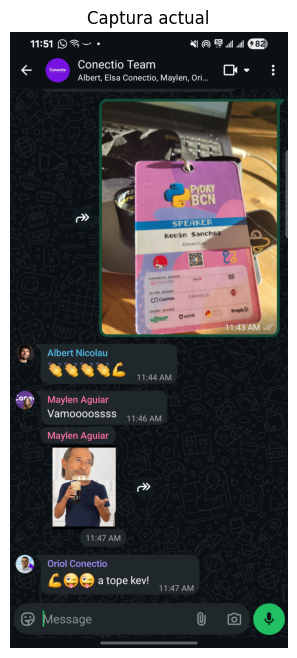

In [4]:
img_bytes = capture_screen()
snapshot = show_screen(img_bytes)

#### Test d'integració DETR

Aquesta cel·la realitza una **prova completa** del pipeline de detecció:

```
Dispositiu Android → Captura → DETR → Visualització
```

**Què fa:**
1. `capture_screen()`: Captura la pantalla actual del dispositiu
2. `detr_detect()`: Aplica el model DETR preentrenat per detectar objectes
3. `visualize_detr_boxes()`: Dibuixa les bounding boxes sobre la imatge

**Què esperem veure:**
- Objectes del dataset COCO (persones, mobles, vehicles, etc.)
- **NO** elements específics de WhatsApp (encara)
- Moltes deteccions **incorrectes** o **irrelevants** per a la nostra tasca

**Per què falla amb WhatsApp:**
El model DETR està entrenat amb imatges naturals (COCO), no amb interfícies d'usuari. Les seves 91 classes no inclouen "message_bubble" o "send_button".

**Solució:** Fine-tuning amb un dataset personalitzat de WhatsApp! (següent secció)


## 4. Detecció amb DETR (Zero-Shot)
Fem una primera proba fent servir DETR (base) preentrenat per obtenir caixes d’objectes a la captura.

#### Funció de visualització de deteccions

La funció `visualize_detr_boxes` dibuixa les bounding boxes detectades sobre la imatge original.

**Paràmetres clau:**
- `threshold`: Només mostra deteccions amb confiança ≥ aquest valor (per defecte 0.5)
- `show_labels`: Si mostrar el nom de la classe i el score
- `model`: El model DETR per obtenir els noms de les classes (`id2label`)


In [7]:
def visualize_detr_boxes(img: Image.Image, results, threshold: float = 0.5, show_labels: bool = True, model = model):
    """Visualitza les caixes de detecció DETR sobre la imatge.
    
    Args:
        img: Imatge PIL
        results: Resultats de DETR (dict amb 'boxes', 'scores', 'labels')
        threshold: Umbral mínim de confiança per mostrar caixes
        show_labels: Si True, mostra etiquetes i scores
    """
    import matplotlib.patches as patches
    
    fig, ax = plt.subplots(1, figsize=(12, 16))
    ax.imshow(img)
    ax.axis('off')
    
    # Obtenir les etiquetes del model
    id2label = model.config.id2label
    
    # Dibuixar cada caixa que supera el threshold
    for score, label, box in zip(results['scores'], results['labels'], results['boxes']):
        if score < threshold:
            continue
            
        x1, y1, x2, y2 = box.tolist()
        width = x2 - x1
        height = y2 - y1
        
        # Crear rectangle
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Afegir etiqueta i score
        if show_labels:
            label_name = id2label.get(int(label), f'Class {int(label)}')
            text = f'{label_name}: {score:.2f}'
            ax.text(
                x1, y1 - 5, text,
                bbox=dict(boxstyle='round', facecolor='red', alpha=0.7),
                fontsize=8, color='white', weight='bold'
            )
    
    plt.title(f'DETR Detections (threshold={threshold})', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return fig, ax


#### Funció de detecció DETR

La funció `detr_detect` aplica el model DETR preentrenat a una captura de pantalla:

```
img_bytes (PNG) → PIL Image → Processor → Model → Post-process → Resultats
```

**Retorna:**
- `img`: Imatge PIL original
- `results`: Dict amb `boxes`, `scores`, `labels` per cada detecció


In [6]:
@torch.no_grad()
def detr_detect(img_bytes: bytes):
    """Aplica DETR a la captura i retorna (imatge PIL, resultats)."""
    img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
    inputs = processor(images=img, return_tensors='pt').to(device)
    outputs = model(**inputs)
    target_sizes = torch.tensor([img.size[::-1]]).to(device)
    results = processor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=0.5
    )[0]
    return img, results


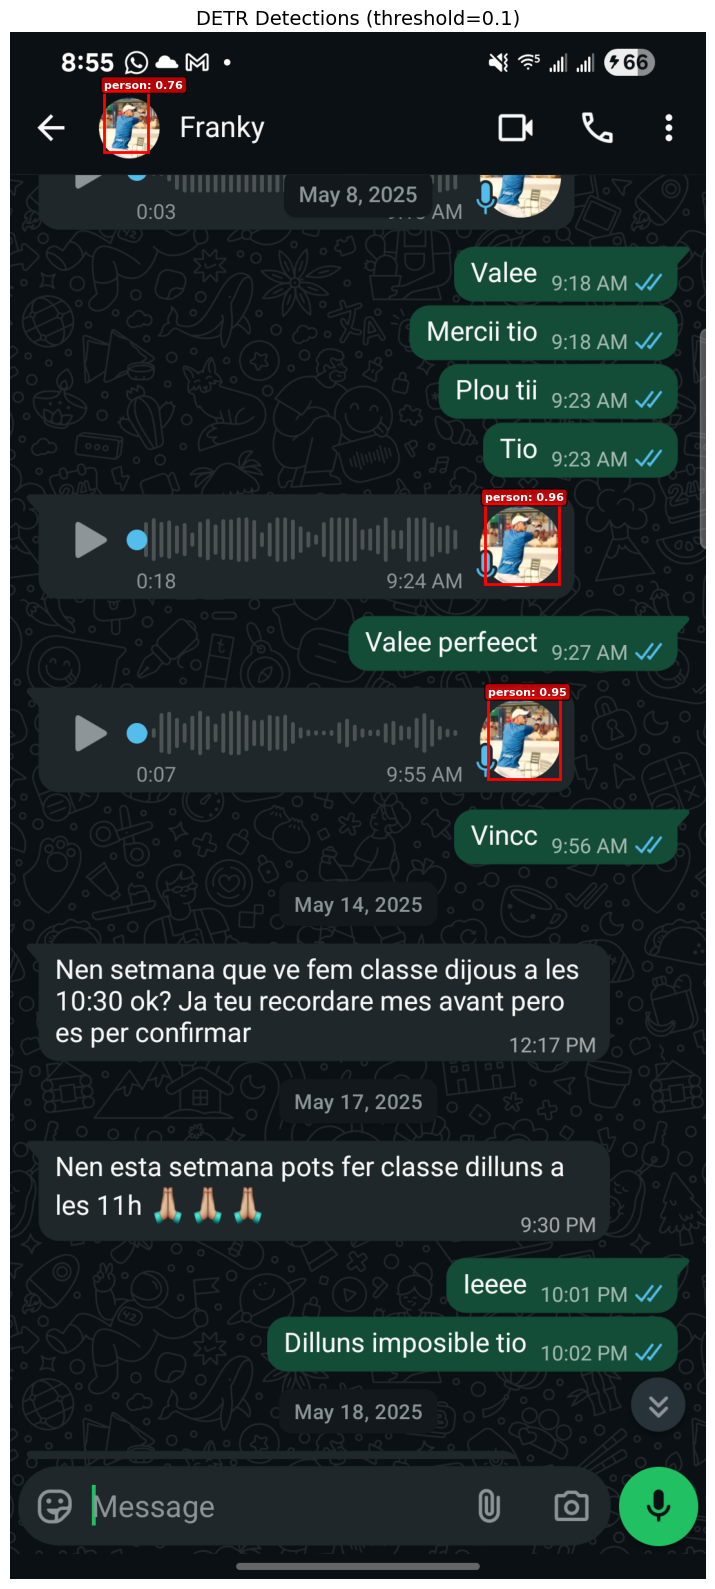

(<Figure size 1200x1600 with 1 Axes>,
 <Axes: title={'center': 'DETR Detections (threshold=0.1)'}>)

In [13]:
# Exemple d'ús: visualitzar les deteccions DETR sobre la imatge
#img_bytes = capture_screen()ç

# Si vols provar amb una imatge local, descomenta la linia següent i comenta la linia de dalt:
with open("whatsapp_0033.png", "rb") as f:
    img_bytes = f.read()


img, results = detr_detect(img_bytes)
visualize_detr_boxes(img, results, threshold=0.1, model = model)


#### Exemple: Executar detecció

Capturem la pantalla actual i executem DETR per detectar objectes. El model preentrenat detectarà objectes del dataset COCO (91 classes com persones, cotxes, etc.), no elements específics de WhatsApp.




Es pot veure clarament com el model preentrenat de DETR no te les classes correctes, i no es adecuat per a realitzar una correcta detecció dels missatges de text i posicións dels elements dins de la interfaç de whatsapp.

## 5. Fine-tuning DETR per a imatges de WhatsApp

Per millorar la precisió de DETR en detectar bombolles de missatges de WhatsApp, podem fer fine-tuning del model amb un dataset personalitzat. Aquest procés implica:

1. **Recopilar un dataset** de captures de pantalla de WhatsApp
2. **Anotar les imatges** amb les caixes de les bombolles de missatges
3. **Entrenar el model** amb aquestes dades
4. **Avaluar i utilitzar** el model fine-tuned


### 5.1. Preparació del dataset

Primer, necessitem recopilar i anotar imatges de WhatsApp. Utilitzarem Label Studio i el format COCO per a les anotacions.


In [16]:
# Definir les classes per a WhatsApp
WHATSAPP_CLASSES = {
    1: "message_bubble_incoming",  # Bombolla de missatge entrant
    2: "message_bubble_outgoing",  # Bombolla de missatge sortint
    3: "input_field",              # Camp d'entrada de text
    4: "send_button",              # Botó d'enviar
    5: "contact_name",             # Nom del contacte
    6: "timestamp",                # Marca de temps
    7: "profile_picture",          # Foto de perfil
}

# Crear estructura (ajusta el path segons necessitat)
# create_coco_dataset_structure("whatsapp_dataset")


#### Helper per recopilar captures de pantalla

Aquesta funció automatitza el procés de captura d'imatges per crear el dataset:

**Procés:**
```
Loop num_images vegades:
  1. Captura pantalla del dispositiu
  2. Guarda com whatsapp_XXXX.png
  3. Espera 2 segons
```

**Paràmetres:**
- `num_images`: Quantes imatges capturar (recomanat: 50-100)
- `output_dir`: On guardar les imatges

**Com utilitzar-ho:**

1. **Abans d'executar:**
   - Obre WhatsApp al dispositiu
   - Navega per diferents converses
   - Assegura't que hi ha varietat (missatges entrants, sortints, diferents longituds)

2. **Durant l'execució:**
   - Canvia manualment entre converses cada 2-3 captures
   - Fes scroll per mostrar diferents missatges
   - Inclou diferents estats (amb teclat, sense teclat, etc.)

3. **Després:**
   - Anota les imatges amb Label Studio
   - Exporta en format COCO JSON

> **Consell**: Més varietat = model més robust. Inclou diferents temes de WhatsApp, idiomes, i densitats de missatges.


#### Definició de classes per WhatsApp

Definim les categories que volem detectar a la interfície de WhatsApp. Cada element de la UI té un identificador únic que utilitzarem durant l'anotació i l'entrenament.

| ID | Classe | Descripció |
|---|--------|------------|
| 1 | message_bubble_incoming | Bombolla de missatge rebut (a l'esquerra) |
| 2 | message_bubble_outgoing | Bombolla de missatge enviat (a la dreta) |
| 3 | input_field | Camp de text per escriure |
| 4 | send_button | Botó d'enviar (icona d'avió/fletxa) |
| 5 | contact_name | Nom del contacte a la capçalera |
| 6 | timestamp | Marca de temps del missatge |
| 7 | profile_picture | Foto de perfil |




A continuació tenim una helper functio que ens ajuda a agafar captures de pantalla del dispositiu móbil, que podrem anotar en label studio.



In [ ]:
def collect_whatsapp_screenshots(num_images: int = 50, output_dir: str = "whatsapp_dataset/images/train"):
    """Recopila captures de pantalla de WhatsApp per al dataset.
    
    Args:
        num_images: Nombre d'imatges a capturar
        output_dir: Directori on guardar les imatges
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    print(f"Capturant {num_images} imatges de WhatsApp...")
    print("Assegura't que WhatsApp està obert al dispositiu Android.")
    
    for i in range(num_images):
        img_bytes = capture_screen()
        if img_bytes:
            img_path = Path(output_dir) / f"whatsapp_{i:04d}.png"
            with open(img_path, 'wb') as f:
                f.write(img_bytes)
            print(f"Imatge {i+1}/{num_images} guardada: {img_path}")
            time.sleep(2)  # Esperar entre captures
        else:
            print(f"Error capturant imatge {i+1}")
    
    print(f"Dataset de {num_images} imatges creat a {output_dir}")

# Per recopilar imatges (descomenta per executar):
collect_whatsapp_screenshots(num_images=50)


### 5.1.2. Eines recomanades per a l'anotació

Per crear les anotacions del dataset, pots utilitzar:

1. **LabelMe** (https://github.com/wkentaro/labelme): Eina gràfica per anotar imatges
2. **CVAT** (https://github.com/openvinotoolkit/cvat): Eina web professional
3. **Label Studio** (https://labelstud.io/): Eina versàtil amb suport COCO
4. **Roboflow** (https://roboflow.com/): Plataforma en línia amb exportació COCO

Totes aquestes eines poden exportar anotacions en format COCO, que és el que utilitzem aquí.


#### Instal·lació de llibreries per fine-tuning

Afegim llibreries addicionals necessàries per a l'entrenament:

| Llibreria | Funció |
|-----------|--------|
| **datasets** | Llibreria de Hugging Face per gestionar datasets |
| **accelerate** | Optimització d'entrenament (suport multi-GPU, mixed precision) |
| **albumentations** | **Data augmentation**: transformacions d'imatges que preserven bounding boxes |

**Per què albumentations?**
- Gestiona automàticament la transformació de bounding boxes quan es modifica la imatge
- Ofereix augmentacions específiques per a object detection
- Millora la robustesa del model amb varietat sintètica

Exemples d'augmentacions que aplicarem:
- Flip horitzontal
- Canvis de brillantor/contrast
- Rotacions petites
- Blur per simular diferents qualitats de pantalla


### 5.2. Entrenament del model fine-tuned

Ara implementem el codi d'entrenament utilitzant la llibreria `transformers` de Hugging Face.


#### Instal·lació de llibreries addicionals

Instal·lem les dependències necessàries per al fine-tuning:
- `datasets`: Gestió eficient de datasets de Hugging Face
- `accelerate`: Acceleració d'entrenament (multi-GPU, mixed precision)
- `albumentations`: Augmentació de dades per a imatges i bounding boxes


#### Pipeline d'augmentació de dades

La funció `get_augmentation_transforms` defineix el **pipeline d'augmentació** que s'aplicarà a cada imatge durant l'entrenament.

**Augmentacions geomètriques:**
```python
A.HorizontalFlip(p=0.5)              # 50% de probabilitat de flip
A.ShiftScaleRotate(rotate_limit=5)   # Rotació màxima de 5° (UI són verticals)
```

**Augmentacions de color:**
```python
A.RandomBrightnessContrast()  # Simula diferents brillantors de pantalla
A.HueSaturationValue()        # Canvis de to (temes de WhatsApp)
A.ColorJitter()               # Variació general de color
```

**Simulació de condicions reals:**
```python
A.GaussNoise()       # Soroll digital
A.GaussianBlur()     # Desenfocat
A.MotionBlur()       # Captura mentre es mou
A.RandomGamma()      # Diferents gammes de pantalla
```

**Normalització:**
```python
A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
```
Valors estàndard d'ImageNet que DETR espera.

**bbox_params crucial:**
```python
bbox_params=A.BboxParams(
    format='coco',           # Format [x, y, width, height]
    label_fields=['category_ids'],
    min_area=100            # Ignora boxes massa petites
)
```
Indica a albumentations com gestionar les bounding boxes.


### Per què la mida del dataset no augmenta?

**Pregunta freqüent:** "Si aplico augmentació, per què `len(dataset)` segueix mostrant 18 imatges?"

**Resposta:** L'augmentació de dades funciona **on-the-fly** (en temps real), no crea fitxers nous!

```
Dataset físic:     18 imatges a disc
                    ↓
Cada cop que accedim a dataset[0]:
                    ↓
    1. Llegeix la imatge original
    2. Aplica transformacions aleatòries
    3. Retorna versió diferent
```

**Exemple pràctic:**
```python
# Les 3 crides retornen imatges DIFERENTS (augmentades diferent)
img1 = dataset[0]  # Flip + brightness + blur
img2 = dataset[0]  # No flip + contrast + noise  
img3 = dataset[0]  # Flip + rotation + gamma
```

**Beneficis:**
- ✅ No ocupa més espai en disc
- ✅ Cada epoch veu versions diferents
- ✅ Dataset "infinit" amb varietat
- ✅ Millor generalització del model

**Durant l'entrenament:**
```
Epoch 1: 18 imatges (augmentades versió A)
Epoch 2: 18 imatges (augmentades versió B)  ← DIFERENTS!
Epoch 3: 18 imatges (augmentades versió C)  ← DIFERENTS!
...
Epoch 30: 18 imatges (augmentades versió AD)
```

En total, el model veu **540 versions diferents** (18 × 30) de les mateixes 18 imatges!


In [ ]:
%pip install -q datasets accelerate albumentations

### 5.2.1 Data Augmentation

Implementem augmentació de dades per millorar la generalització del model. Albumentations gestiona automàticament la transformació de les bounding boxes quan es transforma la imatge.


#### Dataset personalitzat amb augmentació (AugmentedWhatsAppDataset)

Classe PyTorch Dataset que integra **albumentations** per a augmentació on-the-fly durant l'entrenament.

**Flux de processament:**

```
1. Llegir imatge i anotacions del COCO JSON
       ↓
2. Convertir PIL Image → numpy array
       ↓
3. Aplicar transformacions albumentations
   - Imatge es transforma
   - Bounding boxes s'ajusten automàticament
       ↓
4. Normalitzar bounding boxes a [0, 1]
   - Format COCO [x, y, w, h] absolut
   → Format DETR [cx, cy, w, h] normalitzat
       ↓
5. Convertir a tensors PyTorch
       ↓
6. Retornar dict amb pixel_values, pixel_mask, labels
```

**Conversió de bounding boxes crítica:**
```python
# COCO: [x, y, width, height] en píxels
→ Convertir a [x1, y1, x2, y2]
→ Calcular centre: cx = (x1 + x2) / 2
→ Normalitzar: cx_norm = cx / image_width
→ Format final: [cx_norm, cy_norm, w_norm, h_norm] en [0, 1]
```

**Shift de category_id:**
```python
category_id + 1  # DETR espera 0 = background
```

**Per què augmentació on-the-fly?**
- Cada epoch veu versions diferents de cada imatge
- No cal crear físicament múltiples versions
- Estalvia espai en disc


In [66]:
import albumentations as A
import numpy as np

def get_augmentation_transforms(train=True):
    """Retorna les transformacions d'augmentació per a entrenament o validació.
    
    Albumentations gestiona automàticament la transformació de les bounding boxes.
    """
    if train:
        return A.Compose([
            # Redimensionar mantenint l'aspect ratio
            A.LongestMaxSize(max_size=1333),
            A.PadIfNeeded(min_height=800, min_width=800, border_mode=0, value=(128, 128, 128)),
            
            # Augmentacions geomètriques (adaptades per UI)
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.05, 
                scale_limit=0.1, 
                rotate_limit=5,  # Rotació mínima per UI
                border_mode=0,
                p=0.3
            ),
            
            # Augmentacions de color
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=20, p=1),
                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1),
            ], p=0.5),
            
            # Simular diferents condicions de pantalla
            A.OneOf([
                A.GaussNoise(var_limit=(10.0, 30.0), p=1),
                A.GaussianBlur(blur_limit=(3, 5), p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ], p=0.2),
            
            # Ajustar gamma per simular diferents brillantors de pantalla
            A.RandomGamma(gamma_limit=(80, 120), p=0.3),
            
            # Normalització (igual que DETR original)
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            
        ], bbox_params=A.BboxParams(
            format='coco',  # [x, y, width, height]
            label_fields=['category_ids'],
            min_area=100,  # Ignorar bboxes molt petites
            min_visibility=0.3,  # Ignorar bboxes massa retallades
        ))
    else:
        # Validació: només redimensionar i normalitzar
        return A.Compose([
            A.LongestMaxSize(max_size=1333),
            A.PadIfNeeded(min_height=800, min_width=800, border_mode=0, value=(128, 128, 128)),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ], bbox_params=A.BboxParams(
            format='coco',
            label_fields=['category_ids'],
        ))

print("Transformacions d'augmentació definides!")


Transformacions d'augmentació definides!


In [67]:
from torch.utils.data import Dataset

class AugmentedWhatsAppDataset(Dataset):
    """Dataset amb augmentació de dades per a WhatsApp."""
    
    def __init__(self, coco_file: str, images_dir: str, processor, train: bool = True):
        with open(coco_file, 'r') as f:
            self.coco_data = json.load(f)
        
        self.images_dir = Path(images_dir)
        self.processor = processor
        self.train = train
        self.transform = get_augmentation_transforms(train=train)
        
        # Crear mapping d'imatges i anotacions
        self.image_dict = {img['id']: img for img in self.coco_data['images']}
        self.annotations_dict = {}
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.annotations_dict:
                self.annotations_dict[img_id] = []
            self.annotations_dict[img_id].append(ann)
    
    def __len__(self):
        return len(self.coco_data['images'])
    
    def __getitem__(self, idx):
        image_info = self.coco_data['images'][idx]
        image_id = image_info['id']
        
        # Carregar imatge
        image_path = self.images_dir / image_info['file_name']
        image = Image.open(image_path).convert('RGB')
        image_np = np.array(image)
        
        # Obtenir anotacions
        annotations = self.annotations_dict.get(image_id, [])
        
        # Preparar bboxes i category_ids per albumentations
        bboxes = []
        category_ids = []
        for ann in annotations:
            bbox = ann['bbox']  # [x, y, width, height] format COCO
            # Assegurar que són floats i clamp per evitar valors fora de la imatge
            x, y, w, h = [float(v) for v in bbox]
            # Assegurar que les coordenades estan dins de la imatge
            x = max(0, min(x, image_np.shape[1] - 1))
            y = max(0, min(y, image_np.shape[0] - 1))
            w = max(1, min(w, image_np.shape[1] - x))
            h = max(1, min(h, image_np.shape[0] - y))
            bboxes.append([x, y, w, h])
            category_ids.append(int(ann['category_id']) + 1)  # +1 per background
        
        # Aplicar augmentació
        if bboxes:
            try:
                transformed = self.transform(
                    image=image_np,
                    bboxes=bboxes,
                    category_ids=category_ids
                )
                image_np = transformed['image']
                bboxes = transformed['bboxes']
                category_ids = transformed['category_ids']
            except Exception as e:
                # Si hi ha error en l'augmentació, usar imatge original amb normalització
                print(f"Warning: Error en augmentació per imatge {image_id}: {e}")
                image_np = image_np.astype(np.float32) / 255.0
                image_np = (image_np - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
        else:
            # Sense anotacions, aplicar transformació bàsica
            transformed = self.transform(image=image_np, bboxes=[], category_ids=[])
            image_np = transformed['image']
        
        # Convertir a tensor
        if isinstance(image_np, np.ndarray):
            pixel_values = torch.from_numpy(image_np).permute(2, 0, 1).float()
        else:
            pixel_values = image_np
        
        # Crear pixel_mask (tot 1s per indicar que tota la imatge és vàlida)
        pixel_mask = torch.ones(pixel_values.shape[1:], dtype=torch.long)
        
        # Preparar target per a DETR
        # IMPORTANT: DETR espera boxes normalitzades [0,1] en format [cx, cy, w, h]
        if bboxes:
            boxes = []
            labels = []
            
            # Obtenir mida de la imatge transformada per normalitzar
            img_h, img_w = pixel_values.shape[1], pixel_values.shape[2]
            
            for bbox, cat_id in zip(bboxes, category_ids):
                x, y, w, h = bbox
                # Convertir a [x1, y1, x2, y2]
                x1, y1, x2, y2 = float(x), float(y), float(x + w), float(y + h)
                
                # Normalitzar a [0, 1] i convertir a format DETR [cx, cy, w, h]
                cx = (x1 + x2) / 2.0 / img_w
                cy = (y1 + y2) / 2.0 / img_h
                w_norm = (x2 - x1) / img_w
                h_norm = (y2 - y1) / img_h
                
                # Clamp per assegurar que estan dins [0, 1]
                cx = max(0.0, min(1.0, cx))
                cy = max(0.0, min(1.0, cy))
                w_norm = max(0.001, min(1.0, w_norm))
                h_norm = max(0.001, min(1.0, h_norm))
                
                boxes.append([cx, cy, w_norm, h_norm])
                labels.append(int(cat_id))
            
            target_dict = {
                'image_id': torch.tensor([image_id], dtype=torch.long),
                'class_labels': torch.tensor(labels, dtype=torch.long),
                'boxes': torch.tensor(boxes, dtype=torch.float),
            }
        else:
            target_dict = {
                'image_id': torch.tensor([image_id], dtype=torch.long),
                'class_labels': torch.tensor([], dtype=torch.long),
                'boxes': torch.tensor([], dtype=torch.float).reshape(0, 4),
            }
        
        return {
            'pixel_values': pixel_values,
            'pixel_mask': pixel_mask,
            'labels': target_dict
        }

print("AugmentedWhatsAppDataset definit!")


AugmentedWhatsAppDataset definit!


#### Visualització i diagnòstic d'augmentacions

Aquesta cel·la serveix per **verificar** que les augmentacions funcionen correctament:

**Funció `visualize_augmentation`:**
- Genera múltiples augmentacions de la mateixa imatge
- Dibuixa les bounding boxes transformades
- Permet veure visualment la varietat que creem

**Codi de diagnòstic:**
```python
sample = augmented_dataset[0]
print(f"pixel_values shape: {sample['pixel_values'].shape}")
print(f"Nombre de boxes: {len(sample['labels']['boxes'])}")
```

**Què verifiquem:**

✅ **Boxes normalitzades correctament:**
```
Box values range: 0.022 - 0.954
✅ Boxes correctament normalitzades!
```
Tots els valors han d'estar entre 0 i 1.

✅ **Classes correctes:**
```
0: [0.299, 0.106, 0.292, 0.029] -> msg_out
1: [0.410, 0.142, 0.519, 0.034] -> msg_out
...
```
Les etiquetes corresponen a les categories esperates.

✅ **Format DETR:**
```
[cx, cy, w, h] normalitzat 0-1
```
Centre i dimensions normalitzades.

**Problemes comuns:**
- ❌ Boxes > 1.0 → Normalització incorrecta
- ❌ Classes incorrectes → Problema amb category_id shift
- ❌ Boxes buides → Error en transformacions albumentations

> **Consell**: Executa sempre aquesta cel·la després de modificar el dataset per verificar que tot funciona.


#### Dataset amb Augmentació (AugmentedWhatsAppDataset)

Aquesta classe implementa un `torch.utils.data.Dataset` personalitzat amb augmentació de dades integrada.

**Flux de dades:**
```
COCO JSON → Carregar imatge → Albumentations → Normalitzar boxes → Tensor PyTorch
```

**Característiques clau:**
- Llegeix anotacions en format COCO `[x, y, w, h]`
- Aplica augmentacions geomètriques i de color (només en mode train)
- **Converteix boxes a format DETR**: `[cx, cy, w, h]` normalitzat a `[0, 1]`
- Afegeix +1 als `category_id` per reservar 0 com a classe "background"


#### Visualització d'Augmentacions

La funció `visualize_augmentation` ens permet veure com les augmentacions afecten les imatges i les bounding boxes.

**Què fa:**
- Mostra múltiples versions augmentades de la mateixa imatge base
- Cada crida a `dataset[idx]` aplica augmentacions aleatòries noves
- Desnormalitza la imatge per poder-la visualitzar correctament
- Dibuixa les boxes convertides de `[cx, cy, w, h]` normalitzat a píxels absoluts

**Colors per classe:**
| Color | Classe |
|-------|--------|
| Gris | background |
| Verd llima | contact_name |
| Vermell | input_field |
| Blau | msg_incoming |
| Groc | msg_outgoing |
| Cian | profile_pic |
| Magenta | send_btn |
| Taronja | timestamp |


Funció visualize_augmentation definida!

=== Verificant dataset ===
Dataset amb 18 imatges

=== Diagnòstic mostra 0 ===
pixel_values shape: torch.Size([3, 1333, 800])
Nombre de boxes: 13

Boxes (format [cx, cy, w, h] normalitzat 0-1):
  0: [0.299, 0.106, 0.292, 0.029] -> msg_out
  1: [0.410, 0.142, 0.519, 0.034] -> msg_out
  2: [0.310, 0.182, 0.332, 0.033] -> msg_out
  3: [0.427, 0.218, 0.545, 0.038] -> msg_out
  4: [0.402, 0.350, 0.504, 0.039] -> msg_out
  5: [0.457, 0.400, 0.614, 0.053] -> msg_out
  6: [0.721, 0.900, 0.241, 0.042] -> msg_in
  7: [0.535, 0.285, 0.610, 0.076] -> msg_in
  8: [0.547, 0.953, 0.619, 0.053] -> input
  9: [0.175, 0.954, 0.080, 0.062] -> send
  10: [0.628, 0.054, 0.151, 0.025] -> contact
  11: [0.455, 0.073, 0.109, 0.022] -> time
  12: [0.745, 0.061, 0.075, 0.053] -> profile

Box values range: 0.022 - 0.954
✅ Boxes correctament normalitzades!

Visualitzant augmentacions...


C:\Users\k20_2\AppData\Local\Temp\ipykernel_74216\2467585315.py:13: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=800, min_width=800, border_mode=0, value=(128, 128, 128)),
c:\Users\k20_2\AppData\Local\Python\pythoncore-3.12-64\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\k20_2\AppData\Local\Temp\ipykernel_74216\2467585315.py:34: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 30.0), p=1),


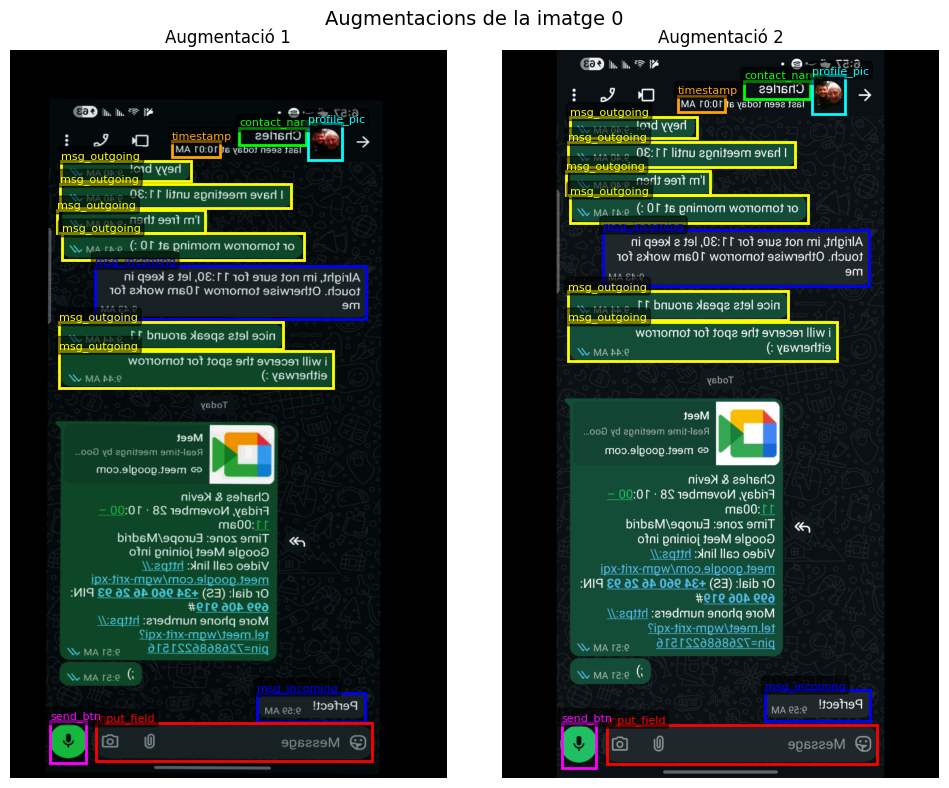

In [68]:
def visualize_augmentation(dataset, idx: int = 0, num_samples: int = 4, id2label: dict = None):
    """Visualitza múltiples augmentacions de la mateixa imatge."""
    import matplotlib.patches as patches
    
    # Mapping de classes per defecte (basat en annotations/train.json + shift +1)
    # COCO: 0=contact_name, 1=input_field, 2=msg_incoming, 3=msg_outgoing, 4=profile, 5=send, 6=timestamp
    # Després del shift +1: 0=background, 1=contact_name, etc.
    if id2label is None:
        id2label = {
            0: "background",
            1: "contact_name",
            2: "input_field", 
            3: "msg_incoming",
            4: "msg_outgoing",
            5: "profile_pic",
            6: "send_btn",
            7: "timestamp"
        }
    
    fig, axes = plt.subplots(1, num_samples, figsize=(5 * num_samples, 8))
    if num_samples == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        sample = dataset[idx]
        
        # Desnormalitzar imatge per visualitzar
        img = sample['pixel_values'].permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
        img = np.clip(img, 0, 1)
        
        img_h, img_w = img.shape[:2]
        
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Augmentació {i+1}')
        
        # Dibuixar bboxes
        boxes = sample['labels']['boxes']
        labels = sample['labels']['class_labels']
        
        colors = ['gray', 'lime', 'red', 'blue', 'yellow', 'cyan', 'magenta', 'orange', 'white']
        
        for box, label in zip(boxes, labels):
            # Convertir de [cx, cy, w, h] normalitzat a [x1, y1, x2, y2] absolut
            cx, cy, w, h = box.tolist()
            x1 = (cx - w/2) * img_w
            y1 = (cy - h/2) * img_h
            x2 = (cx + w/2) * img_w
            y2 = (cy + h/2) * img_h
            
            label_idx = int(label)
            color = colors[label_idx % len(colors)]
            label_name = id2label.get(label_idx, f"Class {label_idx}")
            
            rect = patches.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                linewidth=2, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f'{label_name}', color=color, fontsize=8,
                   bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
    
    plt.suptitle(f'Augmentacions de la imatge {idx}', fontsize=14)
    plt.tight_layout()
    plt.show()

print("Funció visualize_augmentation definida!")

# Crear dataset i verificar dades
print("\n=== Verificant dataset ===")
augmented_dataset = AugmentedWhatsAppDataset('annotations/train.json', 'images/train', processor, train=True)
print(f"Dataset amb {len(augmented_dataset)} imatges")

# Diagnòstic: verificar format de les dades
sample = augmented_dataset[0]
print(f"\n=== Diagnòstic mostra 0 ===")
print(f"pixel_values shape: {sample['pixel_values'].shape}")
print(f"Nombre de boxes: {len(sample['labels']['boxes'])}")

if len(sample['labels']['boxes']) > 0:
    print(f"\nBoxes (format [cx, cy, w, h] normalitzat 0-1):")
    for i, (box, label) in enumerate(zip(sample['labels']['boxes'], sample['labels']['class_labels'])):
        cx, cy, w, h = box.tolist()
        label_name = {0:"bg", 1:"contact", 2:"input", 3:"msg_in", 4:"msg_out", 5:"profile", 6:"send", 7:"time"}.get(int(label), f"?{label}")
        print(f"  {i}: [{cx:.3f}, {cy:.3f}, {w:.3f}, {h:.3f}] -> {label_name}")
    
    box_vals = sample['labels']['boxes']
    print(f"\nBox values range: {box_vals.min():.3f} - {box_vals.max():.3f}")
    if box_vals.max() > 1.0 or box_vals.min() < 0.0:
        print("⚠️  ERROR: Boxes fora del rang [0,1]!")
    else:
        print("✅ Boxes correctament normalitzades!")

# Visualitzar
print("\nVisualitzant augmentacions...")
visualize_augmentation(augmented_dataset, idx=0, num_samples=2)

#### Dataset sense Augmentació (WhatsAppDataset)

Versió del dataset que utilitza el processor de DETR directament sense augmentacions personalitzades.

**Diferències amb AugmentedWhatsAppDataset:**
- Utilitza `DetrImageProcessor` per preprocessar imatges
- No aplica augmentacions geomètriques ni de color
- Útil per validació o quan no es vol augmentació

**Format de sortida idèntic:**
```python
{
    'pixel_values': tensor [3, H, W],      # Imatge normalitzada
    'pixel_mask': tensor [H, W],           # Màscara de píxels vàlids
    'labels': {
        'image_id': tensor,
        'class_labels': tensor [N],         # Classes dels objectes
        'boxes': tensor [N, 4]              # [cx, cy, w, h] normalitzat
    }
}
```


In [69]:
from datasets import load_dataset
from torch.utils.data import Dataset
import torch.nn as nn
from transformers import TrainingArguments, Trainer

class WhatsAppDataset(Dataset):
    """Dataset personalitzat per a WhatsApp amb format COCO."""
    
    def __init__(self, coco_file: str, images_dir: str, processor):
        with open(coco_file, 'r') as f:
            self.coco_data = json.load(f)
        
        self.images_dir = Path(images_dir)
        self.processor = processor
        
        # Crear mapping d'imatges i anotacions
        self.image_dict = {img['id']: img for img in self.coco_data['images']}
        self.annotations_dict = {}
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.annotations_dict:
                self.annotations_dict[img_id] = []
            self.annotations_dict[img_id].append(ann)
    
    def __len__(self):
        return len(self.coco_data['images'])
    
    def __getitem__(self, idx):
        image_info = self.coco_data['images'][idx]
        image_id = image_info['id']
        
        # Carregar imatge
        image_path = self.images_dir / image_info['file_name']
        image = Image.open(image_path).convert('RGB')
        
        # Obtenir anotacions per a aquesta imatge
        annotations = self.annotations_dict.get(image_id, [])
        
        # Preparar anotacions en format COCO per al processor
        # DETR espera category_id començant des de 1 (0 és background)
        # Però el nostre COCO té category_id començant des de 0
        # Així que afegim 1
        coco_annotations = []
        for ann in annotations:
            # Assegurar-nos que bbox és una llista de números, no strings
            bbox = ann['bbox']
            if isinstance(bbox, str):
                import ast
                bbox = ast.literal_eval(bbox)
            elif not isinstance(bbox, list):
                bbox = list(bbox)
            
            coco_annotations.append({
                'id': int(ann['id']),
                'category_id': int(ann['category_id']) + 1,  # Shift per tenir 0 com a background
                'bbox': [float(x) for x in bbox],  # Format COCO: [x, y, width, height]
                'area': float(ann['area'])
            })
        
        # Processar amb el processor de DETR
        if coco_annotations:
            target = {
                'image_id': image_id,
                'annotations': coco_annotations
            }
            encoding = self.processor(
                images=image,
                annotations=[target],
                return_tensors="pt"
            )
        else:
            # Si no hi ha anotacions, processar només la imatge
            encoding = self.processor(
                images=image,
                return_tensors="pt"
            )
        
        # Eliminar batch dimension
        pixel_values = encoding['pixel_values'].squeeze(0)
        pixel_mask = encoding['pixel_mask'].squeeze(0)
        
        # Preparar target per a DETR
        # IMPORTANT: DETR espera boxes normalitzades [0,1] en format [cx, cy, w, h]
        if coco_annotations:
            boxes = []
            labels = []
            
            # Obtenir mida de la imatge processada per normalitzar
            img_h, img_w = pixel_values.shape[1], pixel_values.shape[2]
            
            for ann in coco_annotations:
                x, y, w, h = ann['bbox']
                # Convertir a [x1, y1, x2, y2]
                x1, y1, x2, y2 = float(x), float(y), float(x + w), float(y + h)
                
                # Normalitzar a [0, 1] i convertir a format DETR [cx, cy, w, h]
                cx = (x1 + x2) / 2.0 / img_w
                cy = (y1 + y2) / 2.0 / img_h
                w_norm = (x2 - x1) / img_w
                h_norm = (y2 - y1) / img_h
                
                # Clamp per assegurar que estan dins [0, 1]
                cx = max(0.0, min(1.0, cx))
                cy = max(0.0, min(1.0, cy))
                w_norm = max(0.001, min(1.0, w_norm))
                h_norm = max(0.001, min(1.0, h_norm))
                
                boxes.append([cx, cy, w_norm, h_norm])
                labels.append(int(ann['category_id']))
            
            target_dict = {
                'image_id': torch.tensor([image_id], dtype=torch.long),
                'class_labels': torch.tensor(labels, dtype=torch.long),
                'boxes': torch.tensor(boxes, dtype=torch.float),
            }
        else:
            # Si no hi ha anotacions, crear target buit
            target_dict = {
                'image_id': torch.tensor([image_id], dtype=torch.long),
                'class_labels': torch.tensor([], dtype=torch.long),
                'boxes': torch.tensor([], dtype=torch.float).reshape(0, 4),
            }
        
        return {
            'pixel_values': pixel_values,
            'pixel_mask': pixel_mask,
            'labels': target_dict
        }


### 5.2.2 Custom Collate Function

La funció `create_collate_fn` és essencial per agrupar múltiples mostres del dataset en un **batch** durant l'entrenament.

**Per què necessitem una funció collate personalitzada?**

- **PyTorch DataLoader** agrupa automàticament les mostres, però DETR té requisits específics:
  1. **pixel_values**: Totes les imatges del batch han de tenir la mateixa mida. Si no és així, les paddeja.
  2. **pixel_mask**: Indica quins píxels són vàlids (no padding).
  3. **labels**: DETR espera una **llista de diccionaris** (un per imatge), no un tensor concatenat.

**Què fa la funció?**

```
batch = [sample_1, sample_2, sample_3, ...]
    ↓
┌────────────────────────────────────────┐
│ 1. Separa pixel_values, masks, labels  │
│ 2. Verifica si totes les imatges       │
│    tenen la mateixa mida               │
│ 3. Si no → padding per igualar mides   │
│ 4. Stack pixel_values i masks          │
│ 5. Manté labels com a llista de dicts  │
└────────────────────────────────────────┘
    ↓
{
  "pixel_values": tensor [B, 3, H, W],
  "pixel_mask": tensor [B, H, W],
  "labels": [dict_1, dict_2, ...]  # llista, no tensor!
}
```

Aquesta estructura és la que el model DETR espera rebre durant el forward pass.


In [70]:
def create_collate_fn(processor):
    """Crea una funció collate_fn que utilitza el processor donat."""
    def collate_fn(batch):
        """Funció per agrupar múltiples mostres en un batch."""
        # Agrupar pixel_values i pixel_mask
        pixel_values_list = [item["pixel_values"] for item in batch]
        pixel_mask_list = [item["pixel_mask"] for item in batch]
        labels_list = [item["labels"] for item in batch]
        
        # DETR processor ja retorna imatges de la mateixa mida, només cal fer stack
        # Però per seguretat, verifiquem que totes tenen la mateixa mida
        first_shape = pixel_values_list[0].shape
        all_same_size = all(pv.shape == first_shape for pv in pixel_values_list)
        
        if not all_same_size:
            # Si hi ha diferents mides, paddejar manualment
            import torch.nn.functional as F
            # Trobar la mida màxima
            max_h = max(pv.shape[1] for pv in pixel_values_list)
            max_w = max(pv.shape[2] for pv in pixel_values_list)
            
            batch_pixel_values = []
            batch_pixel_mask = []
            
            for pv, pm in zip(pixel_values_list, pixel_mask_list):
                pad_h = max_h - pv.shape[1]
                pad_w = max_w - pv.shape[2]
                
                if pad_h > 0 or pad_w > 0:
                    pv = F.pad(pv, (0, pad_w, 0, pad_h), value=0)
                    pm = F.pad(pm, (0, pad_w, 0, pad_h), value=0)
                
                batch_pixel_values.append(pv)
                batch_pixel_mask.append(pm)
            
            pixel_values = torch.stack(batch_pixel_values)
            pixel_mask = torch.stack(batch_pixel_mask)
        else:
            # Totes tenen la mateixa mida, només cal fer stack
            pixel_values = torch.stack(pixel_values_list)
            pixel_mask = torch.stack(pixel_mask_list)
        
        # DETR espera labels com a llista de dicts, un per imatge
        # No concatenem, mantenim la llista
        labels_batch = labels_list
        
        return {
            "pixel_values": pixel_values,
            "pixel_mask": pixel_mask,
            "labels": labels_batch
        }
    return collate_fn


#### Funció Principal de Fine-Tuning

La funció `fine_tune_detr_for_whatsapp` és el nucli de l'entrenament. Gestiona tot el procés de fine-tuning.

**Passos que realitza:**

```
1. Carregar processor i configuració COCO
       ↓
2. Calcular num_labels (categories + 1 per background)
       ↓
3. Crear mappings id2label i label2id
       ↓
4. Carregar model preentrenat amb ignore_mismatched_sizes=True
       ↓
5. Crear datasets (AugmentedWhatsAppDataset)
       ↓
6. Configurar TrainingArguments
       ↓
7. Crear Trainer amb collate_fn personalitzat
       ↓
8. Entrenar i guardar model
```

**Paràmetres recomanats per començar:**
- `num_epochs`: 20-50 (més èpoques = millor, però més temps)
- `batch_size`: 2-4 (depèn de la memòria GPU/RAM)
- `learning_rate`: 1e-5 (conservador per no "oblidar" el que ha après)


In [ ]:
def fine_tune_detr_for_whatsapp(
    train_coco_file: str,
    train_images_dir: str,
    val_coco_file: str = None,
    val_images_dir: str = None,
    output_dir: str = "whatsapp_detr_finetuned",
    num_epochs: int = 10,
    batch_size: int = 4,
    learning_rate: float = 1e-5
):
    """Fine-tune DETR per a detecció de bombolles de WhatsApp.
    
    Args:
        train_coco_file: Path al fitxer COCO d'entrenament
        train_images_dir: Directori amb les imatges d'entrenament
        val_coco_file: Path al fitxer COCO de validació (opcional)
        val_images_dir: Directori amb les imatges de validació (opcional)
        output_dir: Directori on guardar el model entrenat
        num_epochs: Nombre d'èpoques d'entrenament
        batch_size: Mida del batch
        learning_rate: Learning rate per a l'entrenament
    """
    # Carregar model i processor
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
    
    # Llegir el nombre de categories del fitxer COCO
    with open(train_coco_file, 'r') as f:
        coco_data = json.load(f)
    num_categories = len(coco_data.get('categories', []))
    
    # DETR necessita num_labels = num_categories + 1 (perquè 0 és background)
    # Com que les nostres categories comencen des de 0, després del shift (+1) tindrem:
    # background=0, category_0=1, category_1=2, ..., category_N=N+1
    # Per tant, num_labels = num_categories + 1
    num_labels = num_categories + 1
    
    print(f"Nombre de categories al COCO: {num_categories}")
    print(f"Nombre de labels per al model (incloent background): {num_labels}")
    
    # Verificar que totes les category_ids al COCO estiguin en el rang vàlid
    max_cat_id = max((cat['id'] for cat in coco_data.get('categories', [])), default=-1)
    min_cat_id = min((cat['id'] for cat in coco_data.get('categories', [])), default=-1)
    print(f"Rang de category_ids al COCO: {min_cat_id} a {max_cat_id}")
    print(f"Després del shift (+1), els labels seran: {min_cat_id+1} a {max_cat_id+1}")
    
    if max_cat_id >= num_categories:
        raise ValueError(f"category_id {max_cat_id} està fora del rang vàlid (0-{num_categories-1})")
    
    # Crear mappings id2label i label2id ABANS de carregar el model
    # Label 0 és background, labels 1-N són les nostres categories
    id2label = {0: "background"}
    label2id = {"background": 0}
    
    # Afegir les categories del COCO (shift +1 perquè 0 és background)
    for cat in coco_data.get('categories', []):
        cat_id = cat['id'] + 1  # Shift +1
        cat_name = cat['name']
        id2label[cat_id] = cat_name
        label2id[cat_name] = cat_id
    
    print(f"id2label: {id2label}")
    
    # Carregar el model amb el nombre correcte de classes des del principi
    # Això assegura que la funció de pèrdua es creï amb el nombre correcte de classes
    model = DetrForObjectDetection.from_pretrained(
        "facebook/detr-resnet-50",
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True  # Permet carregar amb diferent nombre de classes
    )
    
    print(f"Model carregat amb {model.config.num_labels} classes")
    
    # Assegurar-nos que el model estigui en mode entrenament
    model.train()
    
    model.to(device)
    
    # Crear datasets amb augmentació de dades
    print("\nCreant dataset amb augmentació de dades...")
    train_dataset = AugmentedWhatsAppDataset(train_coco_file, train_images_dir, processor, train=True)

    print(f"Nombre d'imatges al dataset augmentat: {len(train_dataset)}")
    
    # Verificar que tots els labels al dataset estiguin en el rang vàlid
    print("\nVerificant labels al dataset...")
    max_label = 0
    min_label = float('inf')
    for i in range(min(10, len(train_dataset))):  # Verificar les primeres 10 mostres
        sample = train_dataset[i]
        if len(sample['labels']['class_labels']) > 0:
            labels = sample['labels']['class_labels']
            max_label = max(max_label, labels.max().item())
            min_label = min(min_label, labels.min().item())
    
    if len(train_dataset) > 0:
        print(f"Rang de labels trobats: {min_label} a {max_label}")
        if max_label >= num_labels or min_label < 0:
            raise ValueError(f"Labels fora del rang vàlid! Esperat: 0-{num_labels-1}, trobat: {min_label}-{max_label}")
    
    if val_coco_file and val_images_dir:
        val_dataset = AugmentedWhatsAppDataset(val_coco_file, val_images_dir, processor, train=False)
    else:
        val_dataset = None
    

    
    # Configurar arguments d'entrenament
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        weight_decay=0.01,
        logging_dir=f"{output_dir}/logs",
        logging_steps=10,
        save_steps=100,
        eval_steps=100 if val_dataset else None,
        save_total_limit=3,
        remove_unused_columns=False,
        push_to_hub=False,
    )
    
    # Crear trainer
    collate_fn = create_collate_fn(processor)
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=collate_fn,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=processor,
    )
    
    # Entrenar
    print("Iniciant entrenament...")
    train_results = trainer.train()
    
    # Guardar model final
    # Crear un directori únic per evitar conflictes de fitxers a Windows
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    final_output_dir = f"{output_dir}_{timestamp}"
    
    print(f"\nGuardant model a {final_output_dir}...")
    
    try:
        # Intentar guardar amb safetensors
        trainer.save_model(final_output_dir)
    except Exception as e:
        print(f"Error amb safetensors: {e}")
        print("Intentant guardar amb format PyTorch...")
        # Fallback: guardar sense safetensors
        model.save_pretrained(final_output_dir, safe_serialization=False)
    
    processor.save_pretrained(final_output_dir)
    
    print(f"\nEntrenament completat! Model guardat a {final_output_dir}")
    print(f"Loss final: {train_results.training_loss:.4f}")
    
    return trainer, model, final_output_dir

# Per executar el fine-tuning (descomenta i ajusta els paths):
trainer, model, saved_model_path = fine_tune_detr_for_whatsapp(
    train_coco_file="annotations/train.json",
    train_images_dir="images/train",
    #val_coco_file="whatsapp_dataset/annotations/val.json",
    #val_images_dir="whatsapp_dataset/images/val",
    num_epochs=30,
    batch_size=3
)
print(f"\nModel guardat a: {saved_model_path}")


### 5.3. Utilitzar el model fine-tuned

Un cop entrenat el model, podem carregar-lo i utilitzar-lo igual que el model preentrenat.


#### Carregar i Utilitzar el Model Fine-Tuned

Dues funcions per treballar amb el model entrenat:

**`load_finetuned_detr(model_dir)`**
- Si `model_dir` és `None`, busca automàticament el model més recent
- Carrega el processor i el model des del directori guardat
- Retorna `(processor, model)` llestos per usar

**`detr_detect_finetuned(img_bytes, processor, model, threshold)`**
- Aplica el model fine-tuned a una imatge
- `threshold` baix (0.1) per veure totes les deteccions durant debug
- Mostra informació de diagnòstic si no hi ha deteccions

**Interpretar els resultats:**
| Loss | Threshold recomanat |
|------|---------------------|
| > 3 | 0.1 (model encara aprenent) |
| 2-3 | 0.2-0.3 |
| 1-2 | 0.4-0.5 |
| < 1 | 0.5-0.7 |


In [2]:
import glob

def load_finetuned_detr(model_dir: str = None):
    """Carrega un model DETR fine-tuned per a WhatsApp.
    
    Si no s'especifica model_dir, busca automàticament el directori més recent.
    """
    if model_dir is None:
        # Buscar el directori més recent
        dirs = glob.glob("whatsapp_detr_finetuned*")
        if not dirs:
            raise FileNotFoundError("No s'ha trobat cap model fine-tuned!")
        # Ordenar per data de modificació (més recent primer)
        dirs.sort(key=lambda x: os.path.getmtime(x), reverse=True)
        model_dir = dirs[0]
    
    print(f"Carregant model des de: {model_dir}")
    
    processor = DetrImageProcessor.from_pretrained(model_dir)
    model = DetrForObjectDetection.from_pretrained(model_dir).to(device)
    model.eval()
    
    print(f"Model fine-tuned carregat!")
    print(f"Nombre de classes: {model.config.num_labels}")
    print(f"Classes: {model.config.id2label}")
    
    return processor, model

@torch.no_grad()
def detr_detect_finetuned(img_bytes: bytes, processor, model, threshold: float = 0.1):
    """Aplica DETR fine-tuned a la captura.
    
    Args:
        threshold: Umbral de confiança (0.1 per defecte - molt baix per veure totes les deteccions)
    """
    img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
    inputs = processor(images=img, return_tensors='pt').to(device)
    outputs = model(**inputs)
    target_sizes = torch.tensor([img.size[::-1]]).to(device)
    
    results = processor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=threshold
    )[0]
    
    # Debug: mostrar informació sobre les deteccions
    print(f"\n=== Resultats de detecció (threshold={threshold}) ===")
    print(f"Nombre de deteccions: {len(results['boxes'])}")
    
    if len(results['boxes']) > 0:
        for i, (score, label, box) in enumerate(zip(results['scores'], results['labels'], results['boxes'])):
            label_name = model.config.id2label.get(int(label), f"Class {label}")
            print(f"  {i+1}. {label_name}: {score:.3f}")
    else:
        # Mostrar els scores màxims per veure si el model detecta alguna cosa
        logits = outputs.logits.softmax(-1)[0, :, :-1]  # Excloure "no object"
        max_score = logits.max().item()
        print(f"  Cap detecció! Màxim score trobat: {max_score:.4f}")
        if max_score < 0.1:
            print("  ⚠️  El model no ha après bé. Necessita més entrenament o dades.")
        else:
            print(f"  💡 Prova amb threshold={max_score * 0.5:.2f}")
    
    return img, results

# Exemple d'ús amb el model fine-tuned:
finetuned_processor, finetuned_model = load_finetuned_detr()
# img_bytes = capture_screen()
# img, results = detr_detect_finetuned(img_bytes, finetuned_processor, finetuned_model, threshold=0.1)
# visualize_detr_boxes(img, results, threshold=0.35)

# Agafa la primera imatge del dataset d'entrenament per testejar el model fine-tuned

# # Suposant que tens un directori amb imatges a "dataset/images" (canvia el path si cal)
# import os

dataset_dir = "images/train"
image_files = sorted([f for f in os.listdir(dataset_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

if image_files:
    first_image_path = os.path.join(dataset_dir, image_files[0])
    with open(first_image_path, "rb") as f:
        img_bytes = f.read()
    img, results = detr_detect_finetuned(img_bytes, finetuned_processor, finetuned_model, threshold=0.1)
    visualize_detr_boxes(img, results, threshold=0.4, model = finetuned_model)
else:
    print("No s'han trobat imatges al dataset per fer el test.")




Carregant model des de: whatsapp_detr_finetuned_20251128_212834
Model fine-tuned carregat!
Nombre de classes: 8
Classes: {0: 'background', 1: 'contact_name', 2: 'input_field', 3: 'message_bubble_incoming', 4: 'message_bubble_outgoing', 5: 'profile_picture', 6: 'send_button', 7: 'timestamp'}

=== Resultats de detecció (threshold=0.1) ===
Nombre de deteccions: 100
  1. message_bubble_incoming: 0.331
  2. message_bubble_outgoing: 0.454
  3. message_bubble_incoming: 0.357
  4. message_bubble_outgoing: 0.426
  5. message_bubble_incoming: 0.416
  6. message_bubble_outgoing: 0.381
  7. message_bubble_incoming: 0.418
  8. message_bubble_incoming: 0.433
  9. profile_picture: 0.227
  10. profile_picture: 0.184
  11. message_bubble_outgoing: 0.310
  12. message_bubble_incoming: 0.358
  13. message_bubble_outgoing: 0.350
  14. message_bubble_outgoing: 0.434
  15. input_field: 0.205
  16. message_bubble_incoming: 0.396
  17. profile_picture: 0.271
  18. message_bubble_outgoing: 0.485
  19. message_

NameError: name 'visualize_detr_boxes' is not defined

### 6. Heurística per trobar l’última bombolla de missatge entrant

Considerem que les bombolles de missatge que entrants estan mes avall de la pantalla son les últimes que han entrat. Entre totes les caixes
que compleixin això, agafem la que està més avall (valor `y2` més gran).

In [4]:
def guess_incoming_bubble(img: Image.Image, results, target_classes, threshold=0.4):
    """
    Retorna (label, score, box) de la bombolla (de les target_classes) més avall (més propera al bottom de la imatge), o None si no n'hi ha cap.
    Només retorna bombolles amb score >= threshold.
    box = (x1, y1, x2, y2)
    """
    width, height = img.size
    found = None
    max_y2 = -float("inf")

    for score, label, box in zip(results['scores'], results['labels'], results['boxes']):
        if int(label) in target_classes and float(score) >= threshold:
            x1, y1, x2, y2 = box.tolist()
            # Selecciona la caixa amb y2 (la part inferior) més gran
            if y2 > max_y2:
                max_y2 = y2
                found = (int(label), float(score), (x1, y1, x2, y2))

    return found


## 7. OCR del missatge amb Tesseract

Fem un *crop* de la caixa candidata i hi apliquem `pytesseract` per extreure'n el text.

#### Funció d'OCR

`ocr_from_box` extreu text d'una regió específica de la imatge:

1. Rep la imatge i les coordenades d'una bounding box `(x1, y1, x2, y2)`
2. Retalla la regió de la imatge (`crop`)
3. Aplica Tesseract OCR per extreure el text

**Nota:** La qualitat del text extret depèn de:
- La resolució de la imatge
- El contrast del text
- La mida de la font


In [5]:
def ocr_from_box(img: Image.Image, box):
    x1, y1, x2, y2 = map(int, box)
    crop = img.crop((x1, y1, x2, y2))
    text = pytesseract.image_to_string(crop)
    return text

bubble = guess_incoming_bubble(img, results, [3,4])
text = ocr_from_box(img, bubble[2])
text


'vaia lios pa poder jugar XD 4.96 ayy\n'

## 8. Generació de resposta amb Ollama

Utilitzem un model de xat local per generar respostes en català.

In [21]:
ollama_client = Client(host='http://conectio.es:11434')


def generate_reply(last_message: str) -> str:
    if not last_message.strip():
        return 'No he pogut llegir bé el missatge, pots repetir-ho?'

    messages = [
        {
            'role': 'system',
            'content': 'Ets un assistent amable que respon missatges de WhatsApp en català, de manera breu i natural.'
        },
        {
            'role': 'user',
            'content': f'Missatge rebut: {last_message}'
        }
    ]

    resp = ollama_client.chat(model='gemma3:4b', messages=messages)
    return resp['message']['content']

reply_text = generate_reply(text)
reply_text


'Ei, no tinguis cap remordiment! 😅 El 4.96 és un caos, eh? 😜\n'

#### Funció de Generació de Resposta

`generate_reply` utilitza Ollama per generar una resposta automàtica:

1. Verifica que el missatge no estigui buit
2. Crea un prompt amb el context del sistema (assistent amable en català)
3. Envia la petició al model `gemma2:2b` via API
4. Retorna la resposta generada

**Configuració del prompt:**
- Rol "system": Defineix el comportament de l'assistent
- Rol "user": Conté el missatge rebut que cal respondre


## 9. Escriure i enviar la resposta via `adb`

Fem servir `adb shell input text` i `adb shell input tap`.

In [32]:
import unicodedata

def sanitize_for_adb(text: str) -> str:
    """Converteix el text a ASCII per a ADB (elimina accents i caràcters especials)."""
    # Eliminar accents: à->a, é->e, ç->c, ñ->n, etc.
    text = unicodedata.normalize('NFD', text)
    text = ''.join(c for c in text if unicodedata.category(c) != 'Mn')
    
    # Mapa manual per caràcters que no es converteixen bé
    replacements = {
        'ç': 'c', 'Ç': 'C',
        'ñ': 'n', 'Ñ': 'N',
        'ł': 'l', 'Ł': 'L',
        '·': '.',  # punt volat català
        ''': "'", ''': "'",
        '"': '"', '"': '"',
        '–': '-', '—': '-',
        '…': '...',
        '\n': ' ',  # newlines a espais
        '\r': '',
    }
    for old, new in replacements.items():
        text = text.replace(old, new)
    
    # Eliminar qualsevol caràcter no-ASCII restant
    text = text.encode('ascii', errors='ignore').decode('ascii')
    
    # Escapar caràcters especials per a ADB shell
    text = text.replace(' ', '%s')
    
    return text

def adb_input_text(text: str):
    """Escriu text al dispositiu via adb.

    Substituïm espais per %s perquè `input text` els interpreta com a separadors.
    """
    safe = text.replace(' ', '%s')
    safe = sanitize_for_adb(safe)

    run_adb(['shell', 'input', 'text', safe])


# Ajusta aquestes coordenades al teu dispositiu
SEND_BUTTON_X = 1550
SEND_BUTTON_Y = 2400

def tap_send_button():
    run_adb(['shell', 'input', 'tap', str(SEND_BUTTON_X), str(SEND_BUTTON_Y)])

adb_input_text(reply_text)
tap_send_button()


## 10. Pipeline complet: una auto-resposta

Aquesta funció fa tot el recorregut complet una sola vegada.

#### Funcions d'Entrada ADB

Dues funcions per interactuar amb el dispositiu Android:

**`adb_input_text(text)`**
- Escriu text al camp actiu del dispositiu
- Substitueix espais per `%s` (requerit per ADB)
- Equivalent a: `adb shell input text "text"`

**`tap_send_button()`**
- Simula un tap a les coordenades del botó d'enviar
- ⚠️ **Important**: Ajusta `SEND_BUTTON_X` i `SEND_BUTTON_Y` segons el teu dispositiu!
- Per trobar les coordenades: Activa "Mostrar toques" a les opcions de desenvolupador


In [ ]:
def whatsapp_auto_reply_once(debug: bool = True):
    img_bytes = capture_screen()
    if not img_bytes:
        print('No s\'ha pogut capturar la pantalla.')
        return

    if debug:
        img = show_screen(img_bytes)
    else:
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')

    img, results = detr_detect(img_bytes)
    candidate = guess_incoming_bubble(img, results)
    if candidate is None:
        print('No s\'ha trobat cap bombolla entrant candidata.')
        return

    label, score, box = candidate
    print(f'Bombolla candidata (score={score:.2f}, box={box})')

    msg_text = ocr_from_box(img, box)
    print('Text detectat:')
    print(msg_text)

    reply = generate_reply(msg_text)
    print('Resposta generada:')
    print(reply)

    adb_input_text(reply)
    time.sleep(0.5)
    tap_send_button()
    print('Missatge enviat!')

# Per provar-ho en directe (quan tinguis tot configurat):
# whatsapp_auto_reply_once(debug=True)


#### Generació de respostes amb Ollama

La funció `ollama_chat` genera respostes automàtiques utilitzant un **LLM local**.

**Com funciona:**
```
Missatge d'entrada → Ollama (LLM) → Resposta generada
```

**Paràmetres:**
- `model='qwen2.5:3b'`: Model Qwen 2.5 (3 billion parameters)
  - Lleuger i ràpid
  - Multilíngüe (català, castellà, anglès, etc.)
  - Pots canviar per `llama3`, `mistral`, etc.

**Configuració del prompt:**
```python
system_prompt = "Ets un assistent amable que respon missatges de WhatsApp en català. ..."
```
Defineix la personalitat i l'idioma de les respostes.

**Alternatives a Ollama:**
- API d'OpenAI (GPT-4)
- Anthropic Claude
- Google Gemini
- Llama local amb transformers

> **Prerequisit**: Cal tenir Ollama instal·lat i el model descarregat:
> ```bash
> ollama pull qwen2.5:3b
> ```


In [ ]:
def whatsapp_auto_reply_loop(interval: float = 15.0):
    print('Iniciant loop d\'auto-resposta. Prem Ctrl+C per aturar.')
    last_text = None
    try:
        while True:
            img_bytes = capture_screen()
            if not img_bytes:
                print('No s\'ha pogut capturar la pantalla. Espero...')
                time.sleep(interval)
                continue

            img, results = detr_detect(img_bytes)
            candidate = guess_incoming_bubble(img, results)
            if candidate is None:
                print('Cap bombolla entrant clara. Espero...')
                time.sleep(interval)
                continue

            _, score, box = candidate
            msg_text = ocr_from_box(img, box).strip()

            if not msg_text:
                print('No s\'ha llegit text clar. Espero...')
                time.sleep(interval)
                continue

            if msg_text == last_text:
                print('Ja he respost aquest missatge. Espero...')
                time.sleep(interval)
                continue

            print('Nou missatge detectat:', msg_text)
            reply = generate_reply(msg_text)
            print('Resposta:', reply)
            adb_input_text(reply)
            time.sleep(0.5)
            tap_send_button()

            last_text = msg_text
            time.sleep(interval)
    except KeyboardInterrupt:
        print('Loop aturat per l\'usuari.')

# Per activar el bot:
# whatsapp_auto_reply_loop(interval=20.0)


## 9. Activitats i extensions

- Millorar la heurística de detecció de bombolles entrants (color, mida, posició).
- Detectar també el camp d'entrada i el botó d'enviar amb heurístiques extra.
- Afegir filtres de seguretat (no respondre a paraules sensibles).
- Provar diferents models d'Ollama i estils de resposta.

Aquest notebook és una base per a experiments, demos i formació sobre visió + LLM + control de dispositius.
